OneFormer
===

 * Paper: https://arxiv.org/abs/2205.06230



```bash
pip install torch torchvision
pip install transformers
pip install matplotlib
pip install supervision
```

In [ ]:
import os
import numpy as np
from PIL import Image
import supervision as sv
import matplotlib.pyplot as plt
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = OwlViTProcessor.from_pretrained(
    "google/owlvit-base-patch32"
)
model = OwlViTForObjectDetection.from_pretrained(
    "google/owlvit-base-patch32"
)

In [13]:
def inference(image, text_labels, device="cpu"):
    inputs = processor(
        text=text_labels,
        images=image,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**inputs)

    # Target image sizes (height, width)
    # to rescale box predictions [batch_size, 2]
    target_sizes = torch.tensor([(image.height, image.width)])
    # Convert bboxes to xyxy format
    prediction = processor.post_process_grounded_object_detection(
        outputs=outputs,
        target_sizes=target_sizes,
        threshold=0.1,
        text_labels=text_labels
    )

    return prediction

In [20]:
image_path = "../samples/fruits-01.jpg"

image = Image.open(image_path).convert("RGB")
image = image.resize((image.width // 4, image.height // 4))
print(image.size)

text_labels = [[
    "a photo of cucumber",
    "a photo of blueberries",
    "a photo of raspberries"
]]

preds = inference(
    image, text_labels, device=device
)

print(preds[0].keys())
print(preds[0]["boxes"].shape)
print(preds[0]["text_labels"])

(378, 504)
dict_keys(['scores', 'labels', 'boxes', 'text_labels'])
torch.Size([11, 4])
['a photo of cucumber', 'a photo of blueberries', 'a photo of cucumber', 'a photo of cucumber', 'a photo of cucumber', 'a photo of raspberries', 'a photo of cucumber', 'a photo of cucumber', 'a photo of raspberries', 'a photo of raspberries', 'a photo of raspberries']


In [21]:
def visualize_bboxes(image, preds):
    boxes = preds["boxes"].cpu().numpy()
    scores = preds["scores"].cpu().numpy()
    labels = preds["labels"].cpu().numpy()
    detections = sv.Detections(
        xyxy=boxes,
        class_id=np.array([0] * len(boxes)),
        confidence=scores,
    )
    annotator = sv.BoxAnnotator()
    annotated_image = annotator.annotate(
        scene=image,
        detections=detections,
    )

    return annotated_image

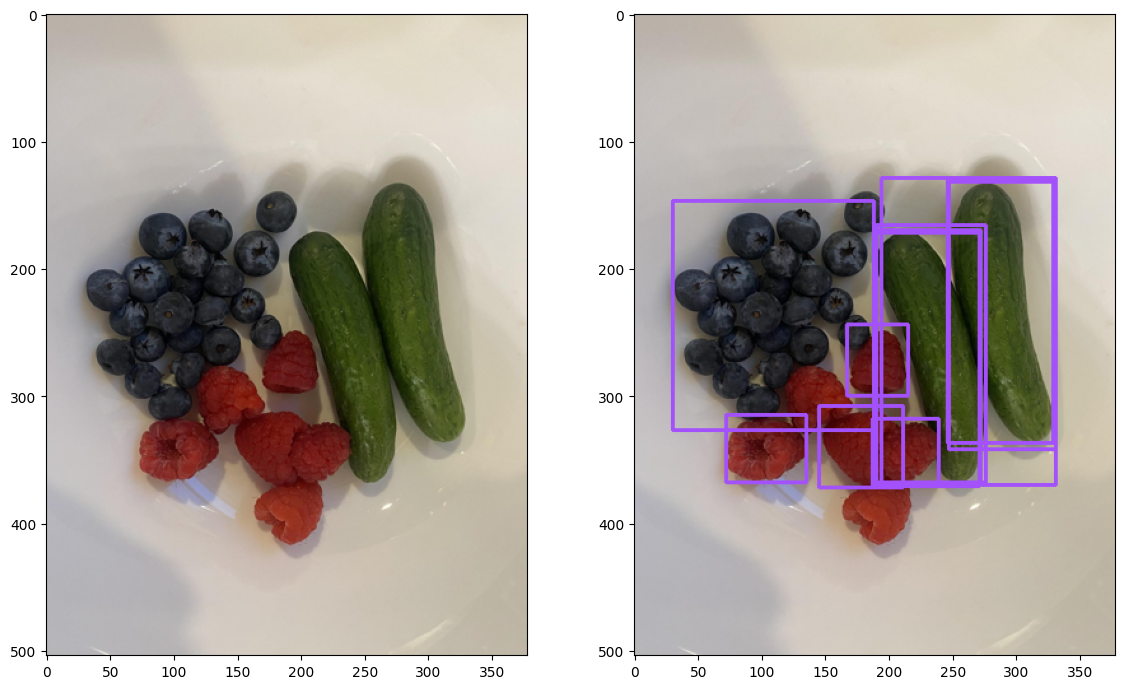

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(image.copy())
axes[1].imshow(visualize_bboxes(image.copy(), preds[0]))
plt.tight_layout()
plt.show()

dict_keys(['scores', 'labels', 'boxes', 'text_labels'])
torch.Size([5, 4])
['a photo of blueberries', 'a photo of raspberries', 'a photo of raspberries', 'a photo of raspberries', 'a photo of raspberries']


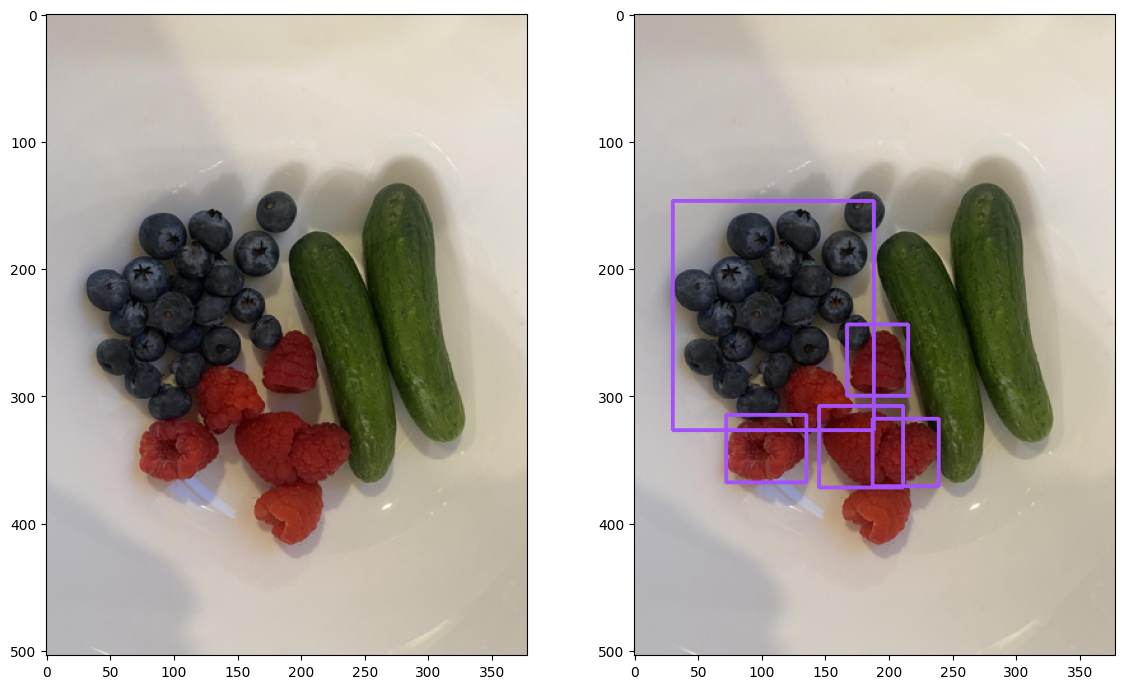

In [16]:
text_labels = [[
    "a photo of blueberries",
    "a photo of raspberries"
]]

preds = inference(
    image, text_labels, device=device
)

print(preds[0].keys())
print(preds[0]["boxes"].shape)
print(preds[0]["text_labels"])

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(image.copy())
axes[1].imshow(visualize_bboxes(image.copy(), preds[0]))
plt.tight_layout()
plt.show()